# ShapeRx - Medical Shape Classification

The plan 
 - [x] download a subset of the labeled vertebrae (see below)
 - [ ] create (small) 2d images from many perspectives based on those 3d models (.stl)
 - [ ] extract labels from filenames
 - [ ] train a model to classify based on aforementioned labels 
 - [ ] check accuracy, etc
 - [ ] tune hyperparameters
 - [ ] repeat with larger image size and more images until we are satisfied or run out of time 
 - [ ] host streamlit, textual or gradio app that serves the model someplace
 - [ ] profit


## Experimentation

### Dataset Exploration and Validation

#### Downloading

See the MSN Streamlit site for individual downloads:  https://medshapenet-ikim.streamlit.app/Download

❗ The dataset has been narrowed to vertebrae (./data/MedShapeNetDataset_vertebrae.txt) and labeled vertebrae (./data/MedShapeNetDataset_vertebrae_labeled.txt). You can fetch all (probably many gigs) with: 

```
wget --content-disposition --trust-server-names -i MedShapeNetDataset_vertebrae_labeled.txt
```

Though we probably only need a small fraction as we can generate arbitrary views with the below open3d helper functions. That is: 
1. import
2. rotate
3. save to PNG at desired size
4. repeat

This will give us as many images at whatever size we want. 

Note: Labels need to be extracted from the filenames. 

#### Visualize w/ Open3d

In [1]:
file = '/Users/jason/Local/school/vision_project/mystery_data/ct_skull_50.stl' 
file2 = '/Users/jason/Local/school/vision_project/mystery_data/917558_skull.stl' 
file3 = '/Users/jason/Local/school/vision_project/mystery_data/150423_skull.stl' 
file4 = 'data/000000_tumoredbrain.stl'
file5 = 'data/000007_vertebrae.stl'
file6 = 'data/001200_vertebrae.stl'
file7 = 'data/002459_vertebraeC1.stl'

In [20]:
import open3d as o3d
import copy 
import numpy as np
from open3d.visualization import rendering


def get_mesh(file): 
    if file.endswith('stl'): 
        return o3d.io.read_triangle_mesh(file)
        
def draw_mesh(mesh): 
    mesh.compute_vertex_normals()
    o3d.visualization.draw_geometries([mesh], width=192, height=108)

def rotate_mesh(mesh): 
    # https://www.open3d.org/docs/latest/tutorial/geometry/transformation.html#Rotation
    mesh_r = copy.deepcopy(mesh)
    R = mesh.get_rotation_matrix_from_xyz((np.pi / 2, 0, np.pi / 4))
    mesh_r.rotate(R, center=(0, 0, 0))

    return mesh_r

def save_image(mesh, h, w, png): 
    # https://github.com/isl-org/Open3D/issues/1095
    vis = o3d.visualization.Visualizer()
    vis.create_window(visible=False, width=w, height=h)
    vis.add_geometry(mesh)
    vis.update_geometry(mesh)
    vis.poll_events()
    vis.update_renderer()
    vis.capture_screen_image(png,do_render=True)
    vis.destroy_window()


def save_image2(mesh, png):           
    # MIT license, derived from open3d 
    #https://www.open3d.org/docs/latest/tutorial/visualization/interactive_visualization.html
    
    # TODO: fix? broken rendering method, can't get the passed mesh to show up in the view

    render = rendering.OffscreenRenderer(640, 480)

    yellow = rendering.MaterialRecord()
    yellow.base_color = [1.0, 0.75, 0.0, 1.0]
    yellow.shader = "defaultLit"

    #mesh.compute_triangle_normals()
    mesh.compute_vertex_normals()

    render.scene.add_geometry("mesh", mesh, yellow)
    render.setup_camera(60.0, [0, 0, 0], [0, 10, 0], [0, 0, 1])
    render.scene.scene.set_sun_light([0.707, 0.0, -.707], [1.0, 1.0, 1.0],75000)
    render.scene.scene.enable_sun_light(True)
    render.scene.show_axes(False)

    img = render.render_to_image()
    o3d.io.write_image(png, img, 9)
    
def save_image3(mesh, png): 

    # TODO: fix? also broken, the add geometry call isn't doing it... similar problem to save_image2

    green = rendering.MaterialRecord()
    green.base_color = [0.0, 0.5, 0.0, 1.0]
    green.shader = "defaultLit"

    w, h = 640, 480
    render = rendering.OffscreenRenderer(w, h)    

    #render.scene.add_model("mesh", mesh)
    render.scene.add_geometry("mesh", mesh, green)

    render.scene.scene.set_sun_light([-1, -1, -1], [1.0, 1.0, 1.0], 100000)
    render.scene.scene.enable_sun_light(True)
    render.scene.show_axes(False)

    aspect = h/w
    s = 3

    render.scene.camera.set_projection(rendering.Camera.Projection.Ortho,-s, s, -s*aspect, s*aspect, 0.1, 200)
    render.scene.camera.look_at([0, 0, 0], [100, 100, 100], [0, 0, 1])

    img = render.render_to_image()
    o3d.io.write_image(png, img)

In [26]:
m = get_mesh(file6)

# pops a dialog, BOLO - ESC to clear
draw_mesh(m)

In [25]:
m2 = rotate_mesh(m)

# pops a dialog, BOLO - ESC to clear
draw_mesh(m2)

In [28]:
save_image(m, h=128, w=128, png='m1.png')
save_image(m2, h=64, w=64, png='m2.png')

#### Visualize w/ numpy-stl

https://github.com/wolph/numpy-stl

In [3]:
import numpy as np
from stl import mesh

In [4]:
mesh2 = mesh.Mesh.from_file(file5)

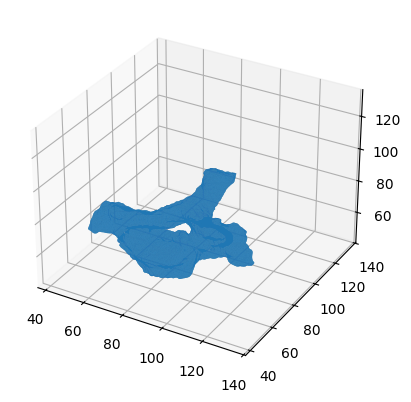

In [5]:
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot

# Create a new plot
figure = pyplot.figure()
axes = figure.add_subplot(projection='3d')

# Add the vectors to the plot
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(mesh2.vectors))

# Auto scale to the mesh size
scale = mesh2.points.flatten()
axes.auto_scale_xyz(scale, scale, scale)

# Show the plot to the screen
pyplot.show()

#### Visualize w/ MSN utilities

The jupyter notebook provided by the MedShapeNet dude (https://colab.research.google.com/github/Jianningli/medshapenet-feedback/blob/main/pip_install_MedShapeNetCore/getting_started.ipynb) suggest we can load and manipulate the datasets with the python library. Let's find out. 

In [30]:
from MedShapeNetCore.MedShapeNetCore import MyDict,MSNLoader,MSNVisualizer,MSNSaver,MSNTransformer

ModuleNotFoundError: No module named 'MedShapeNetCore'

In [5]:
msn_loader=MSNLoader()
msn_vis=MSNVisualizer()
msn_saver=MSNSaver()
msn_transformer=MSNTransformer()

In [6]:
data = msn_loader.load('AutoImplantCraniotomy') 

current dataset: ./medshapenetcore_npz/medshapenetcore_AutoImplantCraniotomy.npz
available keys in the dataset: ['mask']


In [8]:
volume = data['mask']
points = data['point']
#mesh_vertice = data['mesh']['vertices']
mesh_face = data['mesh']['faces']

In [11]:
# data ['mesh'] has no 'vertices' key... 
data['mesh']

MyDict([('faces', MyDict())])

In [9]:
len(volume) 

11

This is wrong?

In [29]:
#print(points.shape) -> doesn't work
#print(volume.shape) -> doesn't work
#print(points.shape) -> doesn't work
#print(mesh_vertice.shape) -> doesn't work
print(mesh_face.shape)
#print(mesh_vertice[0].shape) -> doesn't work

NameError: name 'mesh_face' is not defined

This should also work, per the notebook. 

I guess they never tested the python package with the cranial data? :(

#### Visualize w/ macOS


It turns out macOS has a native STL viewer. Just double click the file to review... 

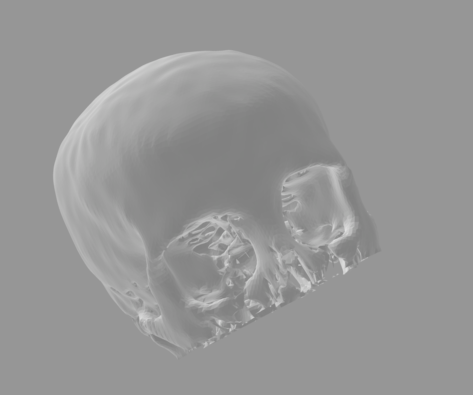

## Dataset Generation 

In [2]:
import open3d as o3d
import copy 
import numpy as np
from open3d.visualization import rendering


def get_mesh(file): 
    if file.endswith('stl'): 
        return o3d.io.read_triangle_mesh(file)
        
def draw_mesh(mesh): 
    mesh.compute_vertex_normals()
    o3d.visualization.draw_geometries([mesh], width=192, height=108)

def rotate_mesh(mesh): 
    # https://www.open3d.org/docs/latest/tutorial/geometry/transformation.html#Rotation
    mesh_r = copy.deepcopy(mesh)
    R = mesh.get_rotation_matrix_from_xyz((np.pi / 2, 0, np.pi / 4))
    mesh_r.rotate(R, center=(0, 0, 0))

    return mesh_r

def save_image(mesh, h, w, png): 
    # https://github.com/isl-org/Open3D/issues/1095
    vis = o3d.visualization.Visualizer()
    vis.create_window(visible=False, width=w, height=h)
    vis.add_geometry(mesh)
    vis.update_geometry(mesh)
    vis.poll_events()
    vis.update_renderer()
    vis.capture_screen_image(png,do_render=True)    
    vis.destroy_window()



In [55]:
import os 
import pandas as pd
import re 

# Create a dataframe that represents everything we've got on disk

def decode_label(filename:str) -> str:
    match = re.search(".*vertebrae_?([A-Z][0-9]).*.stl", filename)
    if match: 
        return match.group(1)
                 
def load_mesh_metadata(dir:str) -> pd.DataFrame: 
    metadata = pd.DataFrame(columns=['filename', 'label'])
    for i, file in enumerate(os.listdir(dir)): 
        if file.endswith('stl'): 
            metadata.loc[i] = {'filename': file, 'label': decode_label(file)}

    return metadata


In [56]:
df = load_mesh_metadata('data/')

In [57]:
df.head()

,filename,label
0,s0197_vertebrae_T7.nii.g_1.stl,T7
1,s0333_vertebrae_C7.nii.g_1.stl,C7
2,061481_vertebraeT7.stl,T7
3,060478_vertebraeL5.stl,L5
4,024073_vertebraeT4.stl,T4


In [71]:
groups = df.groupby(by='label')

In [79]:
groups.count()

,filename
label,
C1,332
C2,331
C3,329
C4,332
C5,348
C6,379
C7,402
L1,495
L2,473


## Model Training

In [ ]:
# Adapated from PyTorch image classifier tutorial - https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html



## Model Validation

## Deployment

TBD - wait to see what the computational and storage requirements are for the classification model and then use a rapid prototyping package like textual or streamlit to mock up a demo. 